#**Network Intrusion Detection**

A network intrusion is an unauthorized penetration of a computer in your enterprise or an address in your assigned domain. Network Intrusion Detection  systems (IDS) are systems that attempt to discover unauthorized access to an enterprise network by analyzing traffic on the network for signs of malicious activity. We evaluate different supervised machine learning algorithms for the task of detecting malicious traffic.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc, roc_curve, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

## Loading the Dataset

We use KDD Cup 1999 Data to build predictive models capable of distinguishing between intrusions and normal connections. It results in 41 features for each connection. Normal connections are created to profile that expected in a military network and attacks fall into one of four categories.

i. User to Root

ii. Remote to Local

iii. Denial of Service

iv. Probe

We will start by extracting feature names from the kddcup names file. Since it does contain any name for the label, we will add a column name 'connection_type' for the labels (target variable).

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/kddcup.data')

In [4]:
kddcup_names = open("/content/gdrive/MyDrive/kddcup.names").read().split('\n')
feature_names = []
for feature_name in kddcup_names[1:]:
    feature_names.append(feature_name.split(':')[0].strip())
feature_names = feature_names[:-1]
feature_names.append("connection_type")

In [5]:
kddcup_data = pd.read_csv("/content/gdrive/MyDrive/kddcup.data", names=feature_names, index_col=False)
kddcup_test_data = pd.read_csv("/content/gdrive/MyDrive/corrected", names=feature_names, index_col=False)

In [6]:
kddcup_data.shape

(4898431, 42)

In [7]:
kddcup_test_data.shape

(311029, 42)

In [9]:
kddcup_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [10]:
kddcup_data.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,normal.


In [11]:
kddcup_data.isnull().sum().sort_values(ascending=True)

duration                       0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_same_src_port_rate    0
dst_host_srv_diff_host_rate    0
dst_host_serror_rate           0
dst_host_srv_serror_rate       0
dst_host_rerror_rate           0
count                          0
is_guest_login                 0
is_host_login                  0
num_outbound_cmds              0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
dst_host_s

## Data Preprocessing

We want to perform numeric encoding on the categorical features. Pandas has a function get_dummies() for this. This function adds additional columns based on the categories present in the feature. To make sure that we have the same number of columns in the train and test sets, we combine the two data sets, perform encoding and then split them back. We also notice that there is a trailing '.' in connection_type normal. We remove the additional '.' for better representation.



In [8]:
data = pd.concat([kddcup_data, kddcup_test_data])

In [9]:
data = pd.get_dummies(data, columns=["protocol_type", "service", "flag"])
data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type,protocol_type_icmp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
train_data = pd.DataFrame(data.iloc[0:4898431,:])
train_data.shape

(4898431, 124)

In [11]:
test_data = pd.DataFrame(data.iloc[4898431:,:])
test_data.shape

(311029, 124)

In [12]:
train_data.connection_type.head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: connection_type, dtype: object

In [13]:
train_data['connection_type'] = train_data['connection_type'].apply(lambda x : str(x)[:-1])
train_data.connection_type.head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: connection_type, dtype: object

In [18]:
train_data = train_data.drop_duplicates()
train_data.shape

(1074992, 124)

## Exploratory Data Analysis

Exploratory data analysis (EDA) is an approach for analyzing the dataset to summarize their main characteristics, often with visual methods. we have used some python libraries like matplotlib, pandas, and seaborn for performing EDA.

The plot below shoes how different attack types are distributed over the dataset. It can be seen by that the distribution of attacks is highly imbalanced.

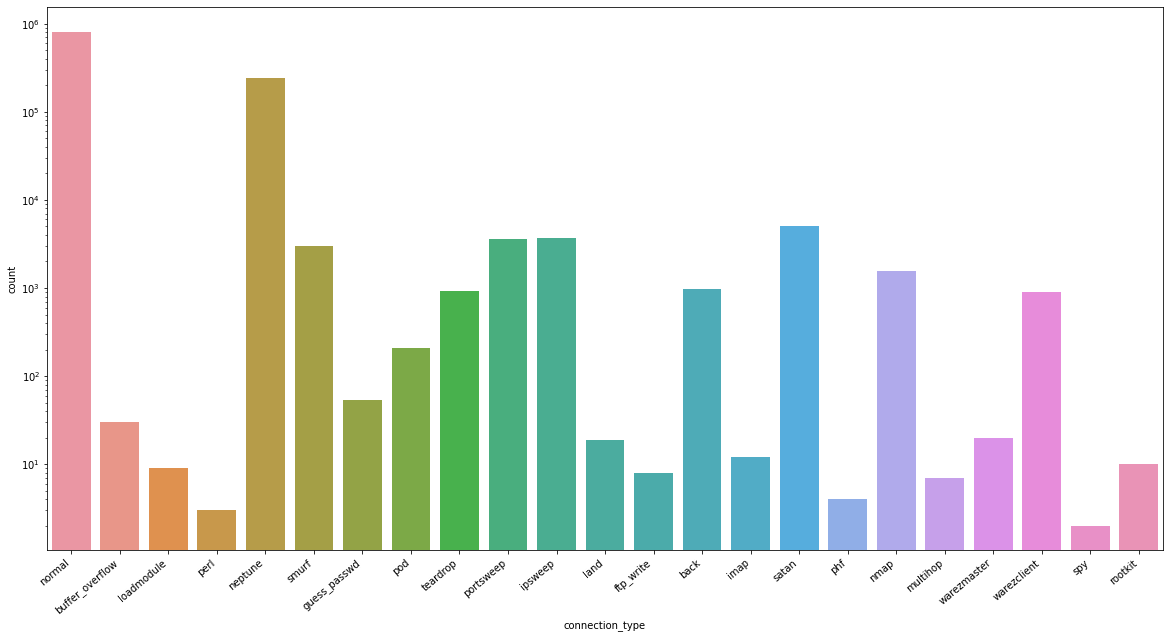

In [32]:
plt.figure(figsize=(20,10))
g = sns.countplot(x = 'connection_type', data = train_data )
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [14]:
train_data["label"] = train_data["connection_type"] != 'normal'
train_data["label"] = train_data["label"].apply(lambda x : int(x))
train_data.label.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

We can see that the number of normal connections is significantly larger the number of attacks. Though this is expected and makes sense, it would not be feasible to use accuracy as the only metric while evaluating a model.

The other thing worth noting is that we have to be careful about false negatives. We cannot afford to have a connection identified as not being malicious when it is an attack. For this, we would plot the ROC curve and use Area Under Curve as an evaluation metric.


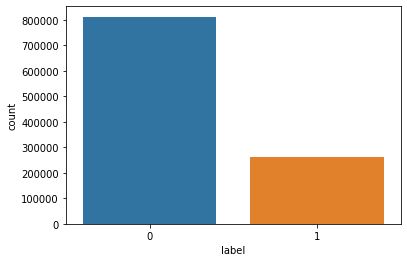

In [34]:
sns.countplot(x = 'label', data = train_data )

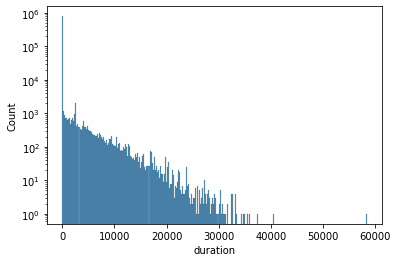

In [29]:
df_normal = train_data[train_data['label']==0]
df_attack = train_data[train_data['label']==1]

g = sns.histplot(x = 'duration', data = df_normal,bins = 300)
g.set_yscale("log")

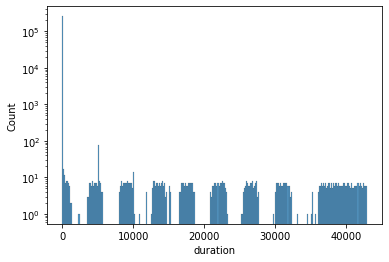

In [30]:
g = sns.histplot(x = 'duration', data = df_attack,bins = 300)
g.set_yscale("log")

Bivariate analysis is done using following function that creates pairplot taking 5 features from our dataset as default parameters along with the output variable. However, none of the pair plots are able to show any linear separability between the different output categories. We can see however see a trend in number (count variable) of packets of different classes associated with the same service (same_serv variable).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

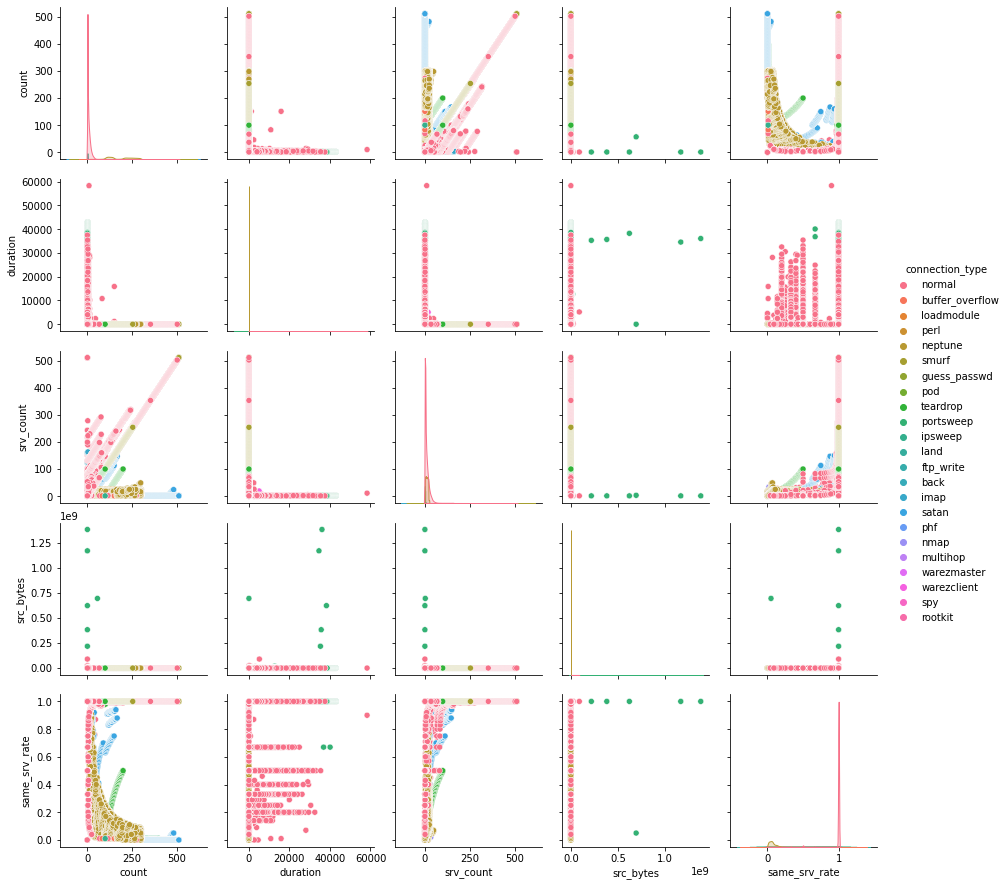

In [19]:
sns.pairplot(train_data, hue ='connection_type', vars = ['count', 'duration','srv_count','src_bytes','same_srv_rate'])

## Model Training and Evaluation

We scale all the numeric features between 0 and 1 so that the model is not biased towards a particular feature.

In [ ]:
numeric_features = train_data.dtypes[train_data.dtypes != "object"].index
min_max_scaler = MinMaxScaler().fit(train_data[numeric_features])
train_data[numeric_features] = min_max_scaler.transform(train_data[numeric_features])
train_data.head()

In [18]:
train_data = train_data.drop("connection_type", axis=1)
train_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,...,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0.0,1.558012e-07,3.441080e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.173944e-07,3.456654e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.003922,0.003922,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.710190e-07,9.374494e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007843,0.007843,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.688450e-07,1.551219e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.011765,0.011765,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.731929e-07,3.710101e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005871,0.005871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.015686,0.015686,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
test_data['connection_type'] = test_data['connection_type'].apply(lambda x : str(x)[:-1])
test_data["label"] = test_data["connection_type"] != 'normal'
test_data["label"] = test_data["label"].apply(lambda x : int(x))
numeric_features = test_data.dtypes[test_data.dtypes != "object"].index
test_data[numeric_features] = min_max_scaler.transform(test_data[numeric_features])
test_data = test_data.drop("connection_type", axis=1)
test_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,...,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,7.608895e-08,1.114557e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.996078,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


We fit four different supervised classifiers on the training data and test it on test set. Different performance metrics are used for evaluation of these classifiers including accuracy, precision, recall, f1 and ROC. 

In [51]:
def classifier(model, X_train, X_test):
  model.fit(X_train.iloc[:,:-1], X_train["label"])
  pred_attack = model.predict(X_test.iloc[:,:-1])
  print(f'Name model: {model}')
  #print(classification_report(X_test['label'],pred_attack))
  print(confusion_matrix(X_test['label'],pred_attack))
  fpr, tpr, thresholds = roc_curve(X_test['label'],pred_attack)
  accuracy = accuracy_score(X_test['label'],pred_attack)
  precision = precision_score(X_test['label'],pred_attack)
  recall = recall_score(X_test['label'],pred_attack)
  f1 = f1_score(X_test['label'],pred_attack)
  roc_auc = auc(fpr, tpr)

  return fpr, tpr, roc_auc, accuracy, precision, recall, f1

In [52]:
fprs = []
tprs = []
roc_aucs = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

model = [RandomForestClassifier(), GradientBoostingClassifier(), Perceptron(),MLPClassifier(hidden_layer_sizes=(100,))]
for m in  model:
  fpr, tpr, roc_auc, accuracy, precision, recall, f1 = classifier(m,train_data,test_data) 
  fprs.append(fpr)
  tprs.append(tpr)
  roc_aucs.append(roc_auc)
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)

Name model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[ 60289    304]
 [ 22626 227810]]
Name model: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                         

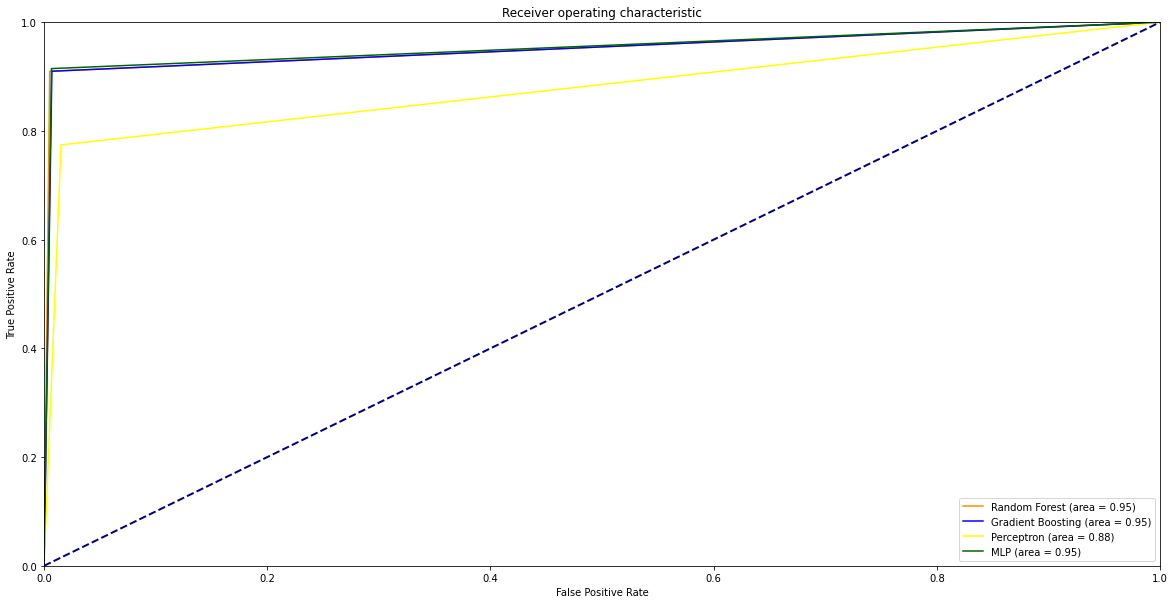

In [53]:
models = ['Random Forest','Gradient Boosting','Perceptron','MLP']
colors = ["darkorange", "blue", "yellow", "darkgreen", "black"]
plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(fprs[i], tprs[i], color=colors[i], label= models[i] + " (area = %0.2f)" % roc_aucs[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

It can be seen that the Random Forest classifier, Gradient Boosting Classifier and Logistic Regression work best for this problem

In [57]:
results_dict = {'Model Name': model,
                'Accuracy': accuracy_list,
                'Precision': precision_list,
                'Recall': recall_list,
                'F1': f1_list
                }

results_df = pd.DataFrame(results_dict)

# sort the results according to F1 score on testing data
results_df.sort_values(by='F1', ascending=False)

,Model Name,Accuracy,Precision,Recall,F1
3,"MLPClassifier(activation='relu', alpha=0.0001,...",0.929987,0.998248,0.914653,0.954624
0,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.926277,0.998667,0.909654,0.952084
1,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.926004,0.998143,0.909793,0.951922
2,"Perceptron(alpha=0.0001, class_weight=None, ea...",0.815319,0.995278,0.774310,0.870998


## Feature Importance
Feature importance can help answer the question, 'Which features have the biggest impact/influence on the output?' 
We'll focus on Permutation Feature Importance. Compared to most other approaches, Permutation Feature Importance is:  

*   fast to calculate,
*   widely used and understood, and
*   consistent with properties we would want a feature importance measure to have.

The Permutation Feature Importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

The above definition might be confused. Here is a clear example to show you how it works: https://www.kaggle.com/dansbecker/permutation-importance

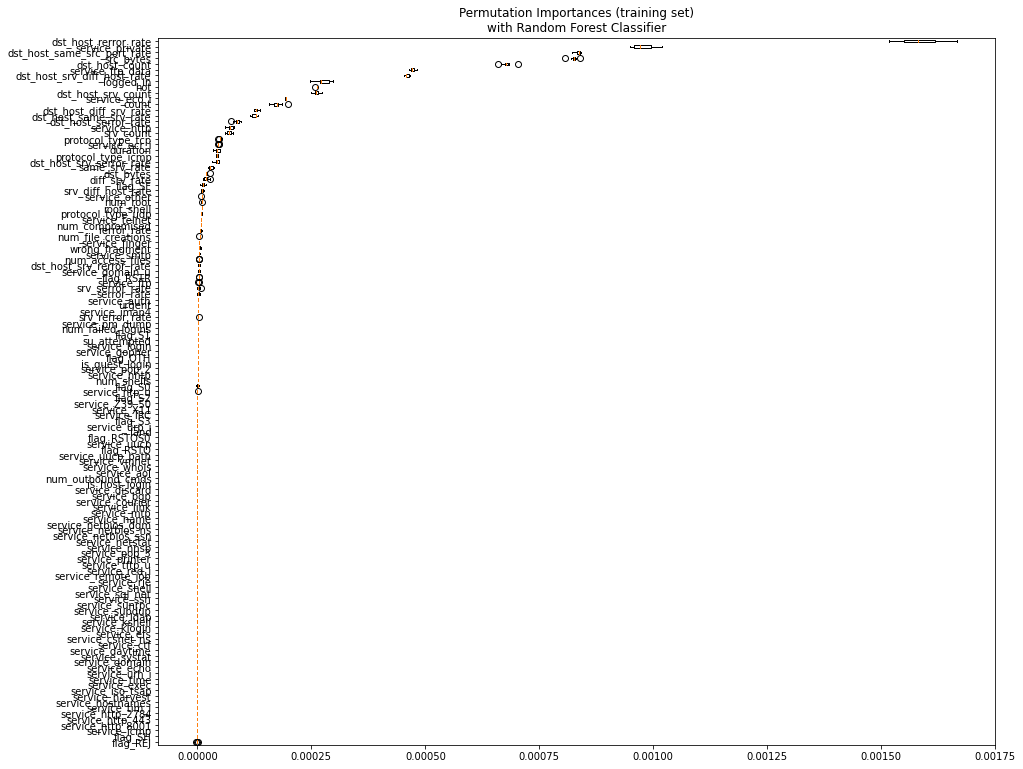

In [21]:
# import permutation function
from sklearn.inspection import permutation_importance

clf_name = 'Random Forest Classifier'
clf = RandomForestClassifier()

new_cols = train_data.iloc[:,:-1].columns

clf.fit(train_data.iloc[:,:-1], train_data["label"])
result = permutation_importance(estimator=clf, 
                                X=train_data.iloc[:,:-1], 
                                y=train_data["label"], 
                                scoring="accuracy",
                                n_repeats=10)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(new_cols)[sorted_idx])
ax.set_title("Permutation Importances (training set)\n"
            "with {}".format(clf_name))

fig.set_size_inches(15, 13)
plt.show()